In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import zscore
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import FunctionTransformer   

In [2]:
df = pd.read_excel('Credit Card Customer Data.xlsx')

In [3]:
#viewing the first rows
df.head(10)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
5,6,58634,20000,3,0,1,8
6,7,48370,100000,5,0,11,2
7,8,37376,15000,3,0,1,1
8,9,82490,5000,2,0,2,2
9,10,44770,3000,4,0,1,7


In [4]:
#checking for null values
df.isnull().any()

Sl_No                  False
Customer Key           False
Avg_Credit_Limit       False
Total_Credit_Cards     False
Total_visits_bank      False
Total_visits_online    False
Total_calls_made       False
dtype: bool

In [5]:
#checking data type
df.dtypes

Sl_No                  int64
Customer Key           int64
Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object

In [6]:
#shape of data
df.shape

(660, 7)

In [7]:
#descrbing data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


In [8]:
#Before we visualize data, we will drop the Si_No and customer key as they both 
#seem to be some sort of client identifier. and they won't really add any value to our clustering
df = df.drop(['Sl_No', 'Customer Key'], axis=1)


Avg_Credit_Limit distribution diagram


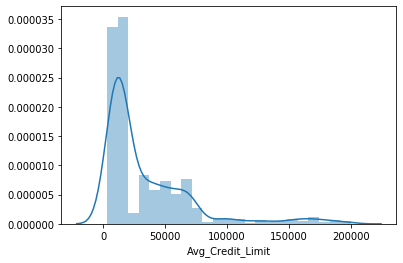

Total_Credit_Cards distribution diagram


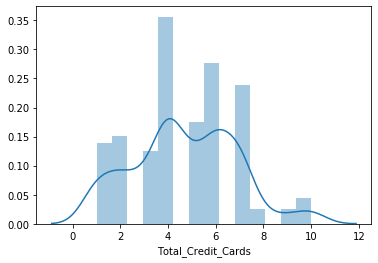

Total_visits_bank distribution diagram


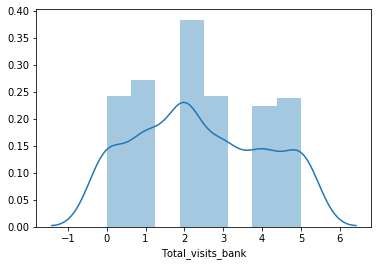

Total_visits_online distribution diagram


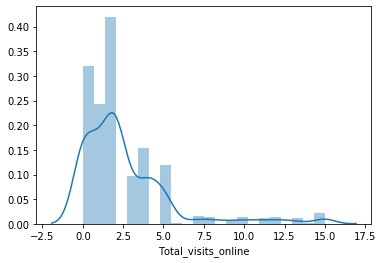

Total_calls_made distribution diagram


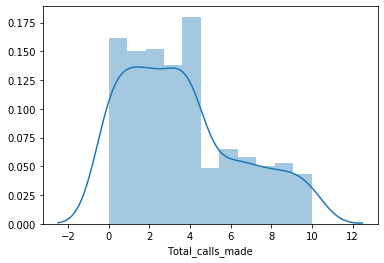

In [9]:
for column in list(df):
    print(f'{column} distribution diagram')
    sns.distplot(df[column], kde=True)
    plt.show()

Avg_Credit_Limit boxplot diagram


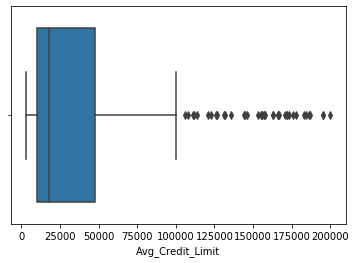

Total_Credit_Cards boxplot diagram


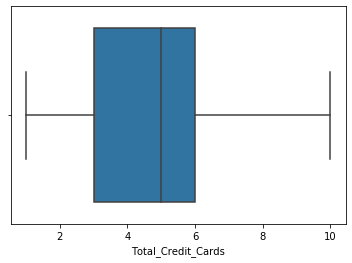

Total_visits_bank boxplot diagram


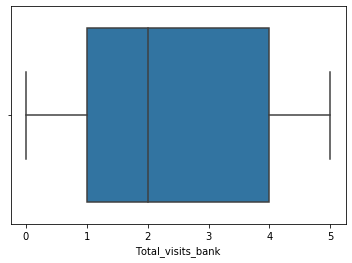

Total_visits_online boxplot diagram


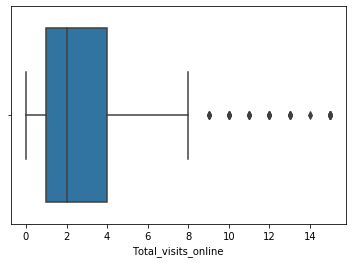

Total_calls_made boxplot diagram


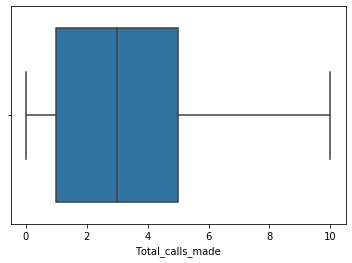

In [10]:
for column in list(df):
    print(f'{column} boxplot diagram')
    sns.boxplot(df[column])
    plt.show()

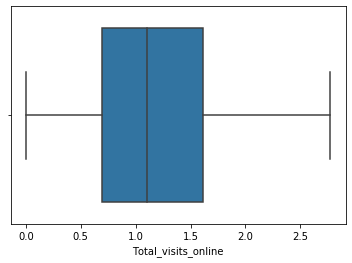

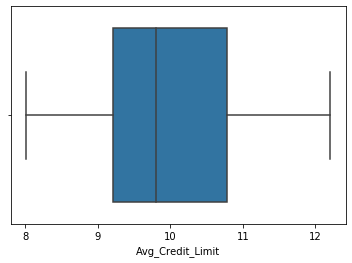

In [11]:
# total visits online and avg credit limit seem highly skewed, we will apply log transformation to them.
df_copy = df.copy()
df_copy['Avg_Credit_Limit'] = np.log(df_copy['Avg_Credit_Limit'] + 1)
df_copy['Total_visits_online'] = np.log(df_copy['Total_visits_online'] + 1)

sns.boxplot(df_copy['Total_visits_online'])
plt.show()
sns.boxplot(df_copy['Avg_Credit_Limit'])
plt.show()

In [12]:
#after the transformation, they both seem great and no more outliers
#applying z-score transformation to get rid of measure units differences.
df_scaled = df_copy.apply(zscore)

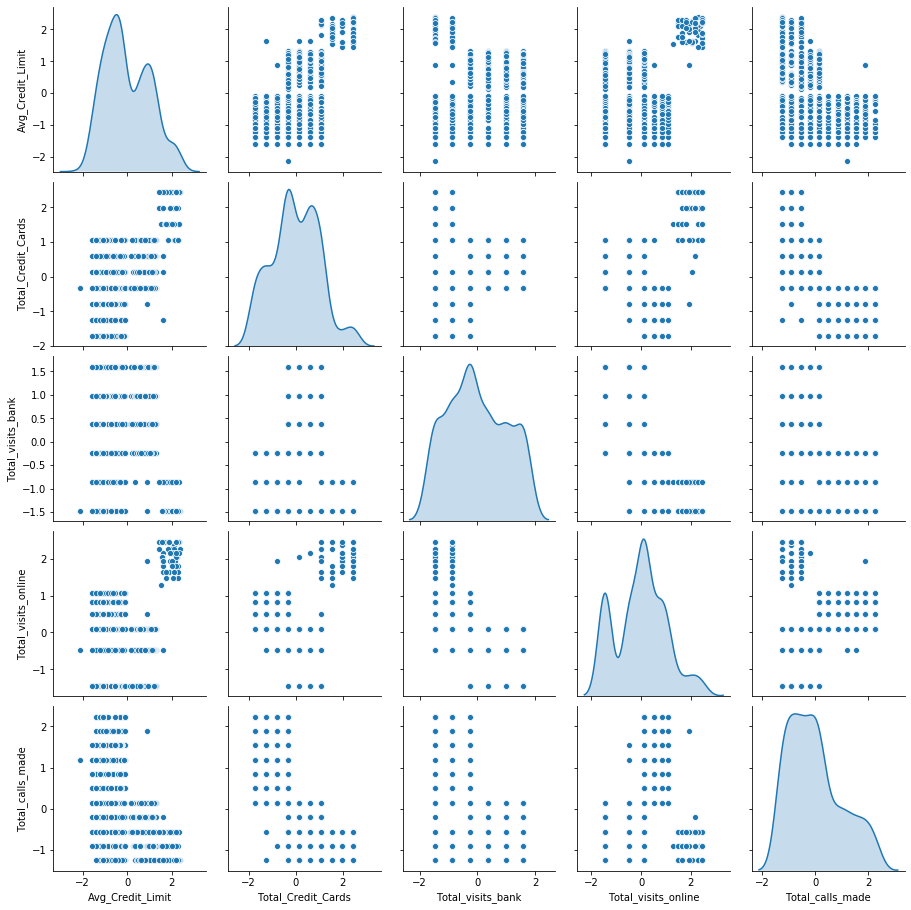

In [13]:
sns.pairplot(df_scaled, diag_kind='kde')

# Notes
Total visits in bank is the graph that indicate the 'highest' minimum number of possible clusters which seem to be 4

# K-Means Clustering 
From the rule k = sqrt(N/2), we know that the maximum number of clusters possible for 660 rows is 17. so we will draw the elbow method from 1 to 17 to try and find the best number of clusters from K-means clustering

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

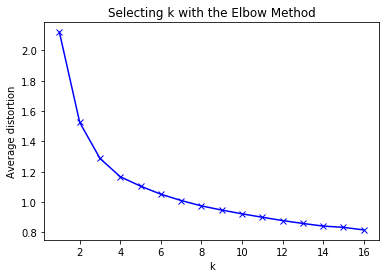

In [14]:
#Finding optimal no. of clusters
clusters=range(1,17)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(df_scaled)
    prediction=model.predict(df_scaled)
    meanDistortions.append(sum(np.min(cdist(df_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / df_scaled.shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

# Notes
from my observations, I think a right value for the number of clusters would be 4 as from there the distribution difference tends to no vary quickly.

Another reason why we are choosing 4 is we have seen that with higher number of clusters, there are many overlaps in clusters and the silhouette score starts to degrade. We also decided to choose 4 as the number of clusters because keeping it small will have more use to the bank. we do not have a lot of columns so explaining many clusters might be complex.

In [15]:
final_model=KMeans(n_clusters=4, n_init=15)
final_model.fit_transform(df_scaled)
prediction=final_model.predict(df_scaled)

df_kmeans = df.copy()
df_kmeans_scaled = df_scaled.copy()

df_kmeans["cluster"] = prediction
df_kmeans_scaled["cluster"] = prediction

print("Clusters Assigned : \n")
df_kmeans.head(20)

Clusters Assigned : 



,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,cluster
0,100000,2,1,1,0,1
1,50000,3,0,10,9,0
2,50000,7,1,3,4,1
3,30000,5,1,1,4,1
4,100000,6,0,12,3,2
5,20000,3,0,1,8,0
6,100000,5,0,11,2,2
7,15000,3,0,1,1,0
8,5000,2,0,2,2,0
9,3000,4,0,1,7,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a21053450>,
      dtype=object)

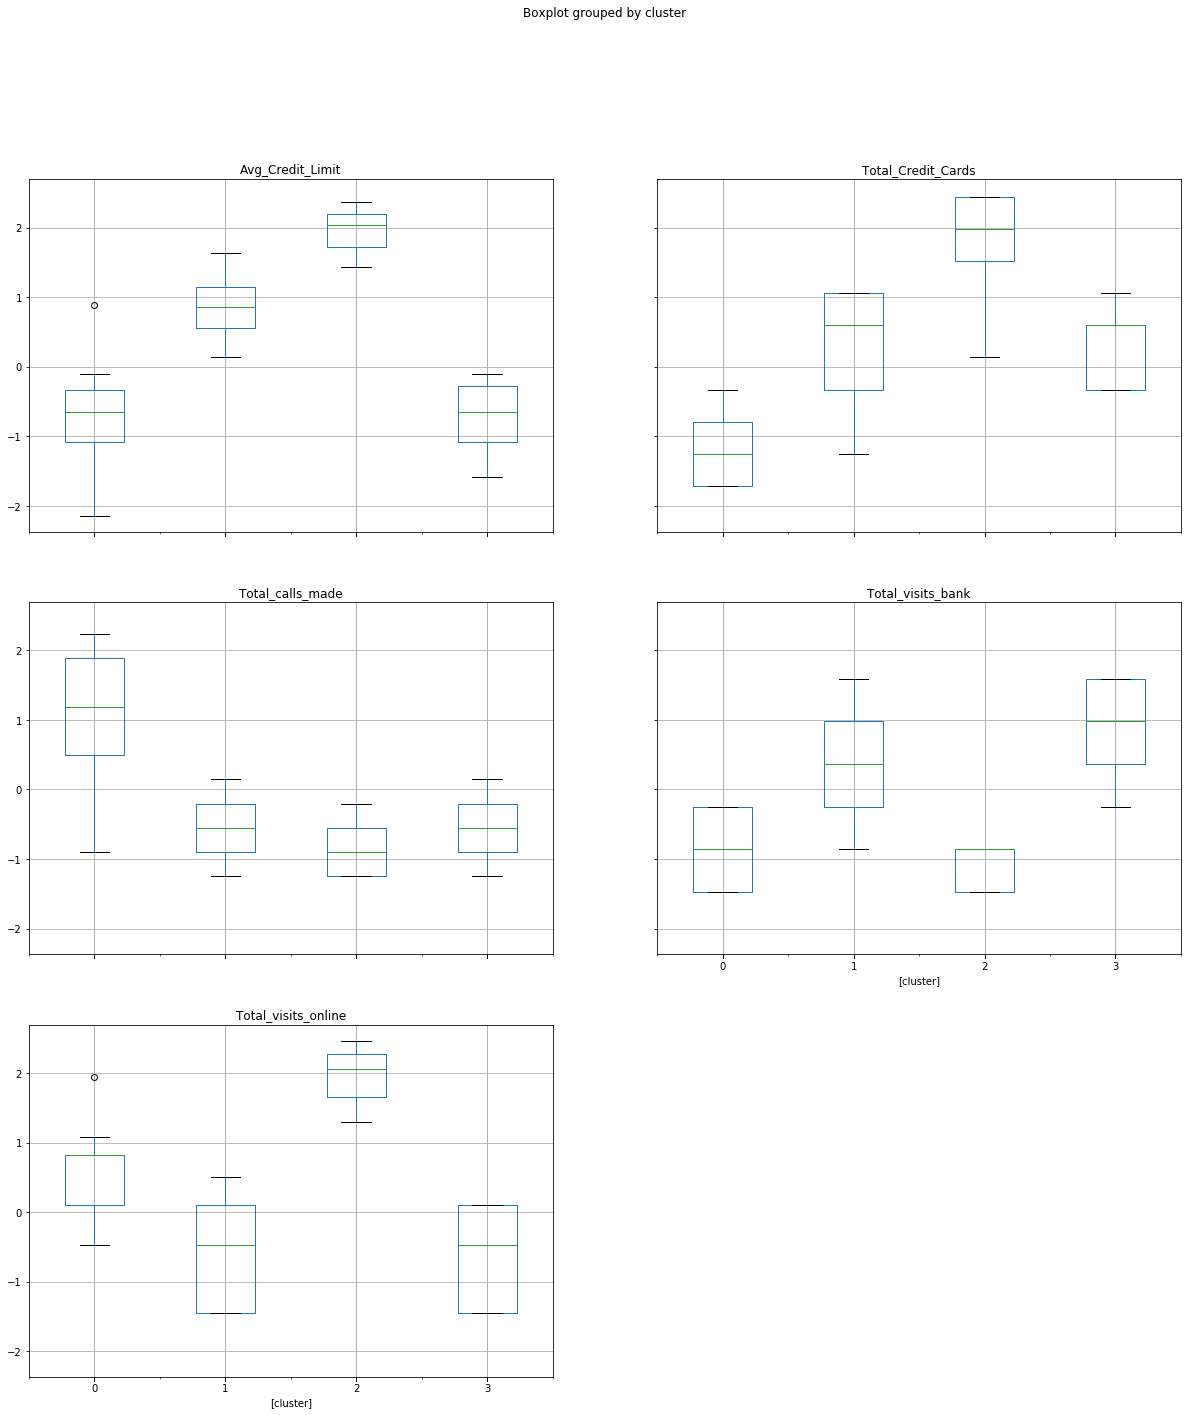

In [16]:
df_kmeans_scaled.boxplot(by='cluster', layout = (4,2),figsize=(20,30))

# K means clusters analysis
1. for avg credit limit, we seem to have two clusters with more or less the same credit limit, and then two others with higher credit limits. 
2. In total credit cards, we see two clusters with some overlap, they have an average number of credit cards. we have another group with higher number of credit cards, and the other one with minimal (close to 0 ) credit cards.
3. In total call made, we have one cluster that has really high number of calls, and the other clusters are quite similar
4. For total visit in the bank, we seem to have two clusters will minimal visits, and two others that visit the bank often to some extent with one of them with a clearyly higher number of visits.
5. For total visit online, we have two clusters with minimal  visits and two others with some amount of visit, cluster 3 seems to have the high number of online visit.

# Hierarchical Clustering
As from elbow, we have seen that we do not have a lot of clusters, we will go with Agglomerative clustering instead of divise clus 

In [17]:
def draw_dendogram(title, Z):
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.xlabel('sample index')
    plt.ylabel('Distance')
    dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8., p=3, truncate_mode='level')
    plt.tight_layout()

for metric euclidean and method average, cophonetic coeff is 0.84927473667065
for metric chebyshev and method average, cophonetic coeff is 0.8470559961575792
for metric euclidean and method centroid, cophonetic coeff is 0.8433942159657706
for metric euclidean and method median, cophonetic coeff is 0.81243025421695
for metric euclidean and method complete, cophonetic coeff is 0.8100445399908286
for metric chebyshev and method complete, cophonetic coeff is 0.7810694053547316
for metric euclidean and method ward, cophonetic coeff is 0.7646785809375133
for metric mahalanobis and method average, cophonetic coeff is 0.7267135289647041
for metric euclidean and method single, cophonetic coeff is 0.6183509759772005
for metric mahalanobis and method single, cophonetic coeff is 0.56847140761739
for metric chebyshev and method single, cophonetic coeff is 0.49805535618012553
for metric mahalanobis and method complete, cophonetic coeff is 0.38576651409450785


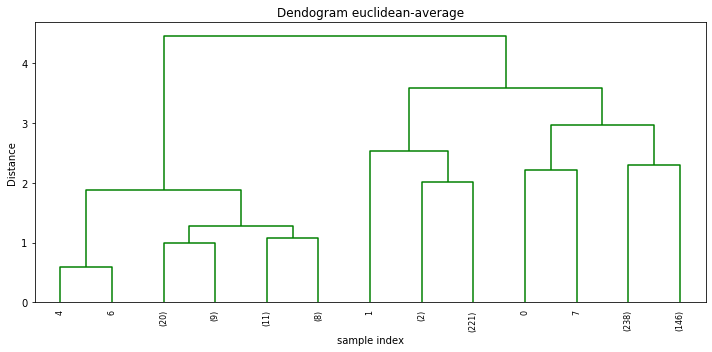

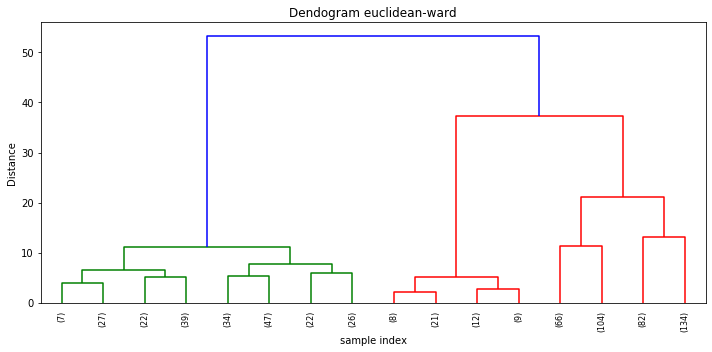

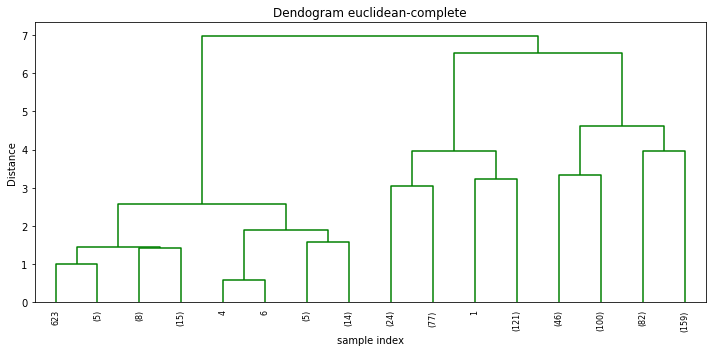

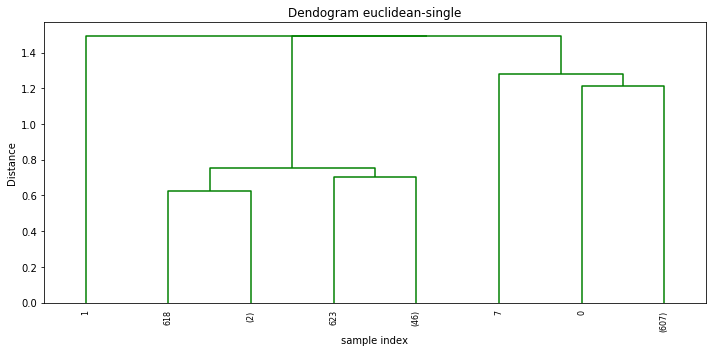

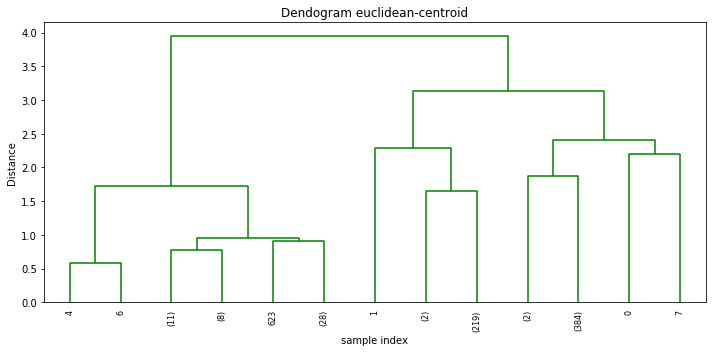

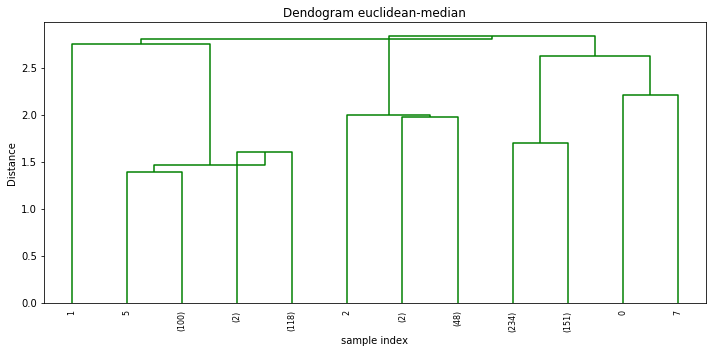

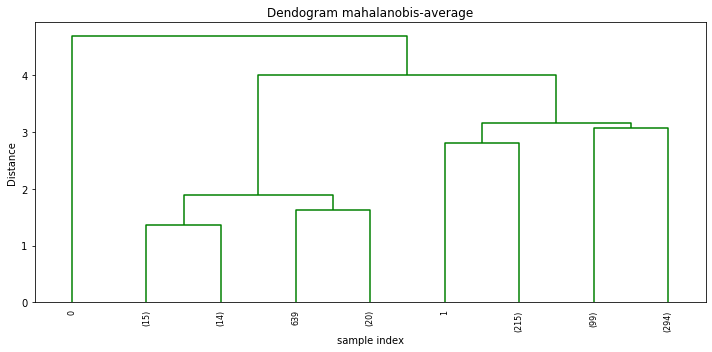

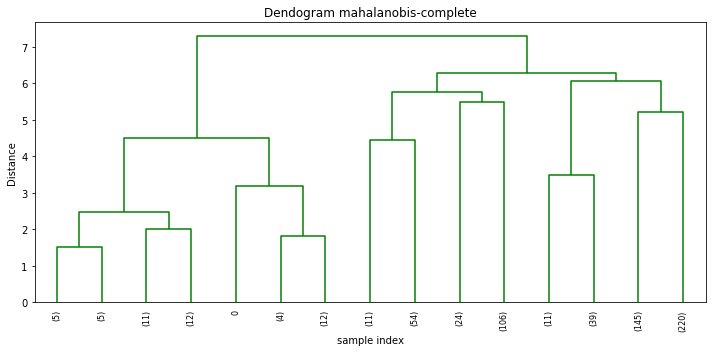

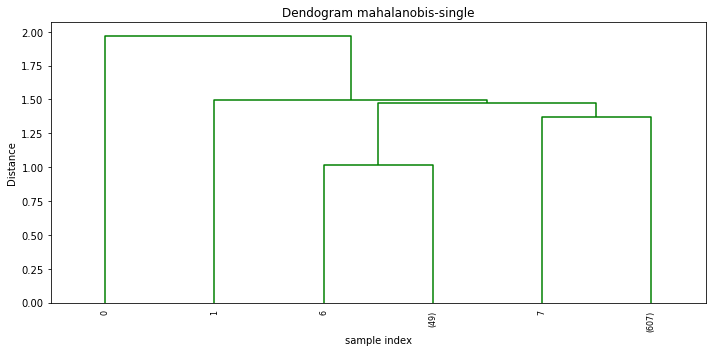

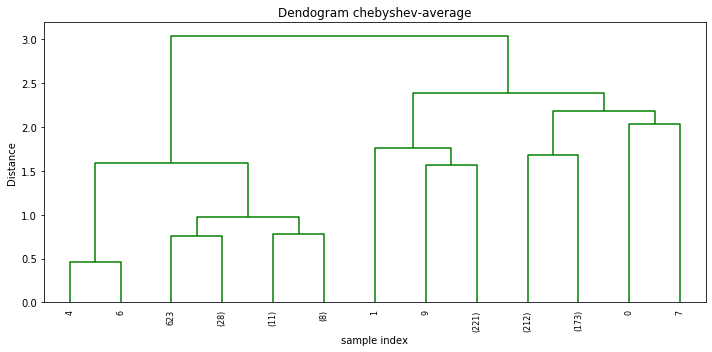

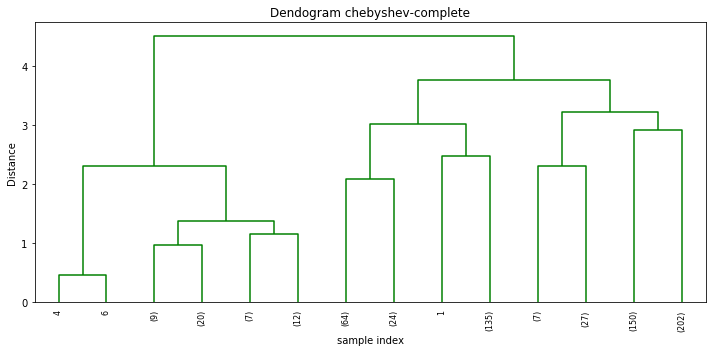

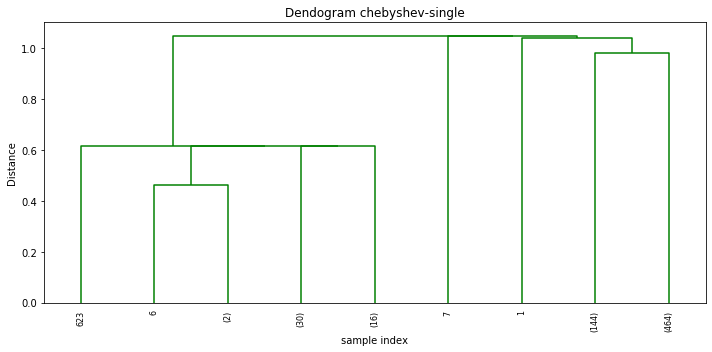

In [18]:
results = []


for metric in ['euclidean', 'mahalanobis', 'chebyshev']:
    for method in ['average', 'ward', 'complete', 'single', 'centroid', 'median']:
        if method in ['ward', 'centroid', 'median'] and metric != 'euclidean':
            #those methods only work with euclidean distance
            continue
        Z = linkage(df_scaled, metric=metric, method=method)
        c, coph_dists = cophenet(Z , pdist(df_scaled))
        result = f'for metric {metric} and method {method}, cophonetic coeff is {c}'
        results.append({'score':c, 'display': result})
        draw_dendogram(f'Dendogram {metric}-{method}', Z)

results = sorted(results, key=lambda k: k['score'], reverse=True)

for result in results:
    print(result['display'])

# Notes
The combination with the best cophonetic correlation coefficient seems to be euclidean metric with average method. so we will use this to compare with k-means.

The different methods seem to have generated rather different clusters, they do not seem similar.

In [19]:
#Building box plot for best hyperparameters (euclidian and average method)
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean',  linkage='average')
model.fit(df_scaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=4)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a22260ad0>,
      dtype=object)

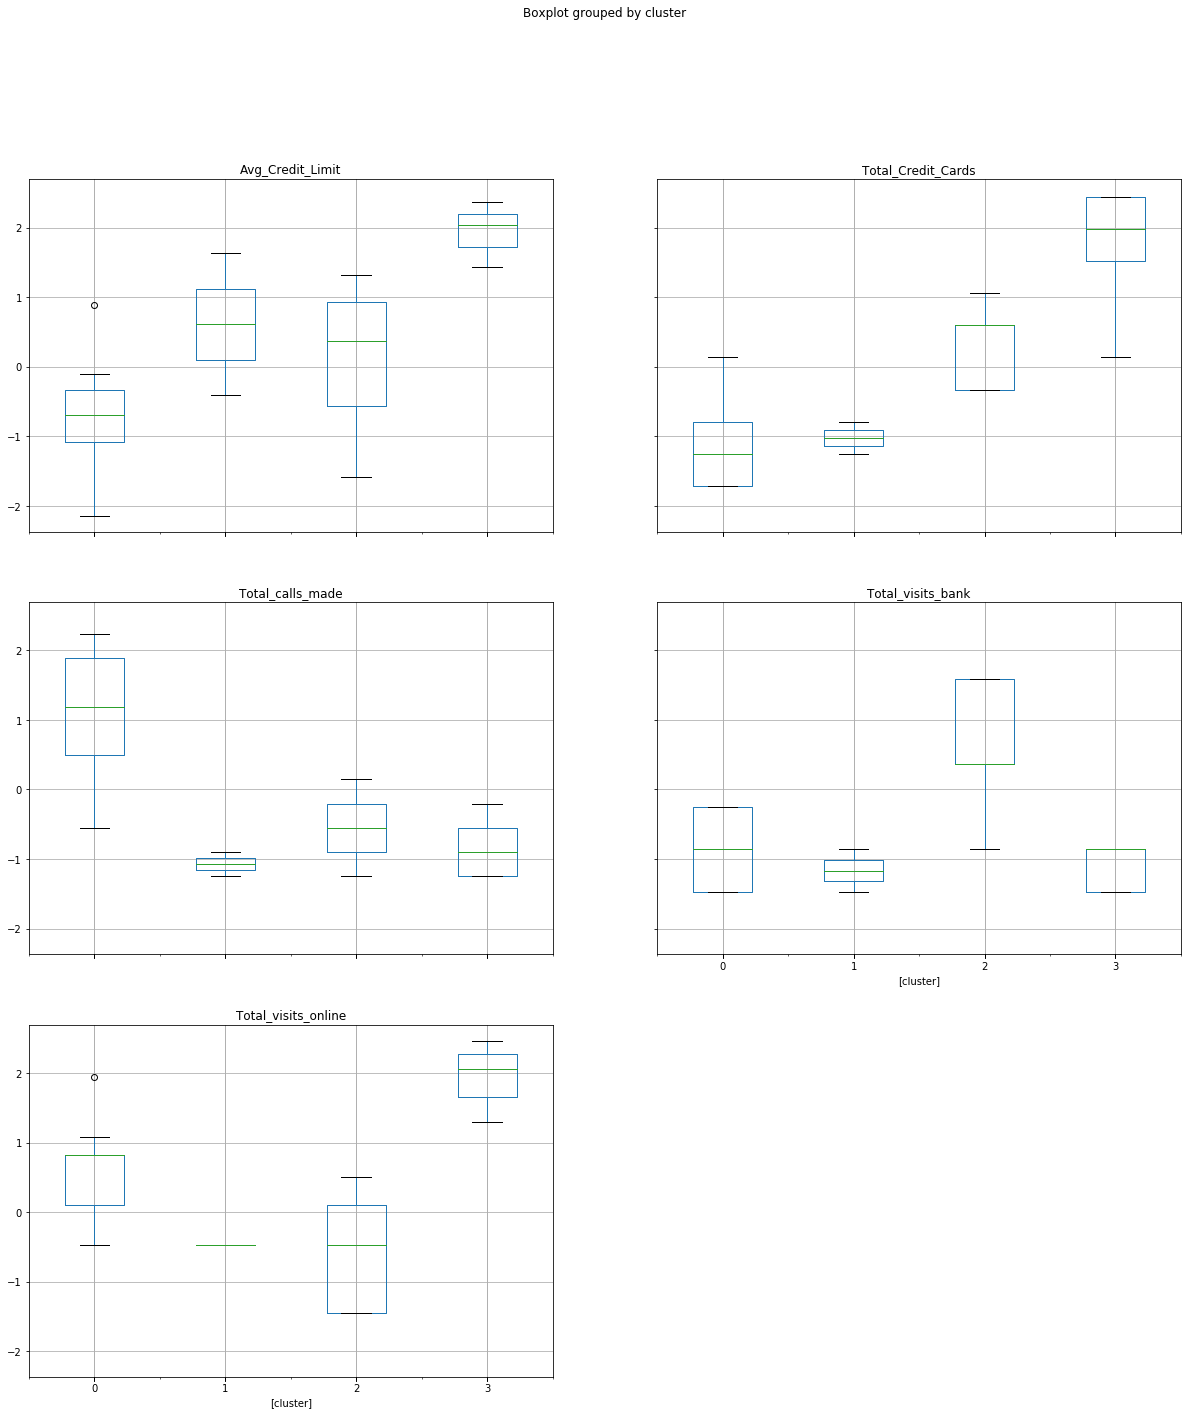

In [20]:
df_hierarchical_scaled = df_scaled.copy()
df_hierarchical_scaled['cluster'] = model.labels_

df_hierarchical_scaled.boxplot(by='cluster', layout = (4,2),figsize=(20,30))

# Hierarchical clusters analysis
the clusters here seem really different from the clusters in k-means
1. for avg credit limit, we seem to have two clusters with more or less the same credit limit, and then two others, one with low credit limit and the other with higher
2. In total credit cards, we see two clusters with some overlap, they have a low number of credit cards. then the other clusters have a higher number of credit cards.
3. In total call made, we have three clusters that have low number of calls, and one with high number of calls
4. For total visit in the bank, we have three clusters that have low number of visits, and one with high number of visits
5. For total visit online,the clusters are clearly distinct

# Kmeans vs Hierarchical Clustering

In [21]:
silhouette_kmeans = silhouette_score(df, df_kmeans['cluster'])
silhouette_hierarchical = silhouette_score(df, df_hierarchical_scaled['cluster'])

print(f'the silhouette score for K-Means is {silhouette_kmeans}')
print(f'the silhouette score for Hierarchical is {silhouette_hierarchical}')

the silhouette score for K-Means is 0.1818073021908935
the silhouette score for Hierarchical is 0.1628873411704146


By taking a look at the silhouette score, it seems K-means in this case is giving the best clusters possible. the cluster score are really low, (close to 0) which means they are not really great

# K-MEANS CLUSTER ANALYSIS
we will make use of the k-means generated clusters to explain the data as it seems to be the best cluster

In [22]:
groups = df_kmeans.groupby(['cluster'])
groups.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
cluster,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536
1,50187.214612,5.547945,3.401826,0.968037,2.054795
2,141040.000000,8.740000,0.600000,10.900000,1.080000
3,12269.461078,5.473054,3.604790,1.000000,1.928144


# Conclusion
1. there are four different segments of customers

2. 
    the first segment is customers with low average credit limit and high number of credit cards. they seem to visit the bank often, they have a minimal online presence and they call rate is low. the best way to personalise campaigns for those customers is by having call centers give them some contents they might be interested in when they come in the branch

    the second segment is customers with low average credit and low number of credit cards. They seem to have little bank visits, they have a more online presence and make calls often. this segment can respond well to campaign run over phone calls. they might also be perceptive to online campaigns

    the third segment is customers with high average credit limit, they seem to have little bank visits and phone calls. they have a really high online presence, thus they will probably respond really well to campaigns run online.

    the fourth segment is customers with medium average credit limit, they seem to have medium bank visits, low online presence and medium phone calls presence. This segment will respond fairly well to campaigns when they visit a branch or over a phone call.

3. Overall, the second segment and third segments are the two segments that we can guarantee will respond extremely well to marketing campaigns run over phone calls and online respectively. marketing campaings in branch might be quite tricky. I think the bank should focus on online and phone calls channel to run their marketing campaigns as segment 2 and 3 will respond well. segment 1 and 4 might be susceptible to phone calls, so that might be a good channel to use for them as well. 
